In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


train = pd.read_csv("data/train.csv")
test= pd.read_csv("data/test.csv")
stores = pd.read_csv("data/stores.csv") 
oil = pd.read_csv("data/oil.csv")     
holiday_events = pd.read_csv("data/holidays_events.csv")     
transactions = pd.read_csv("data/transactions.csv")

In [71]:
# Convert dates
holiday_events['date'] = pd.to_datetime(holiday_events['date'])
oil['date'] = pd.to_datetime(oil['date'])
train['date'] = pd.to_datetime(train['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

# Convert holiday_events types
holiday_events['type'] = holiday_events['type'].astype('category')
holiday_events['locale'] = holiday_events['locale'].astype('category')
holiday_events['locale_name'] = holiday_events['locale_name'].astype('category')
holiday_events['description'] = holiday_events['description'].astype(str)
holiday_events['transferred'] = holiday_events['transferred'].astype(bool)

# Convert oil
oil['dcoilwtico'] = pd.to_numeric(oil['dcoilwtico'], errors='coerce')

# Convert stores
stores['store_nbr'] = stores['store_nbr'].astype('category')
stores['city'] = stores['city'].astype('category')
stores['state'] = stores['state'].astype('category')
stores['type'] = stores['type'].astype('category')
stores['cluster'] = stores['cluster'].astype('int8')

# Convert train
train['id'] = train['id'].astype('int32')
train['store_nbr'] = train['store_nbr'].astype('category')
train['family'] = train['family'].astype('category')
train['sales'] = pd.to_numeric(train['sales'], downcast='float')
train['onpromotion'] = pd.to_numeric(train['onpromotion'], downcast='integer')

# Convert test
test['id'] = test['id'].astype('int32')
test['store_nbr'] = test['store_nbr'].astype('category')
test['family'] = test['family'].astype('category')
test['onpromotion'] = pd.to_numeric(test['onpromotion'], downcast='integer')

# Convert transactions
transactions['store_nbr'] = transactions['store_nbr'].astype('category')
transactions['transactions'] = pd.to_numeric(transactions['transactions'], downcast='integer')



In [72]:
import pandas as pd
# Interpolate missing oil prices
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate().fillna(method='bfill')

# Prepare holiday subsets
holidays = holiday_events[['date', 'locale', 'locale_name', 'type']].copy()
nat_holidays = holidays[holidays['locale'] == 'National'][['date', 'type']].rename(columns={'type': 'nat_holiday'})
reg_holidays = holidays[holidays['locale'] == 'Regional'][['date', 'locale_name', 'type']].rename(columns={'locale_name': 'state', 'type': 'reg_holiday'})
loc_holidays = holidays[holidays['locale'] == 'Local'][['date', 'locale_name', 'type']].rename(columns={'locale_name': 'city', 'type': 'loc_holiday'})

# Merge all data
train_merged = train.merge(stores, on='store_nbr', how='left')
train_merged = train_merged.merge(transactions, on=['date', 'store_nbr'], how='left')
train_merged = train_merged.merge(oil, on='date', how='left')
train_merged = train_merged.merge(nat_holidays, on='date', how='left')
train_merged = train_merged.merge(reg_holidays, on=['date', 'state'], how='left')
train_merged = train_merged.merge(loc_holidays, on=['date', 'city'], how='left')

# Create unified holiday flag
train_merged['is_holiday'] = (
    train_merged['nat_holiday'].notna() |
    train_merged['reg_holiday'].notna() |
    train_merged['loc_holiday'].notna()
).astype(int)

# Fill missing transactions
train_merged['transactions'] = train_merged['transactions'].fillna(0)

# Create time features
train_merged['dayofweek'] = pd.to_datetime(train_merged['date']).dt.dayofweek
train_merged['month'] = pd.to_datetime(train_merged['date']).dt.month
train_merged['year'] = pd.to_datetime(train_merged['date']).dt.year
train_merged['is_weekend'] = train_merged['dayofweek'].isin([5, 6]).astype(int)


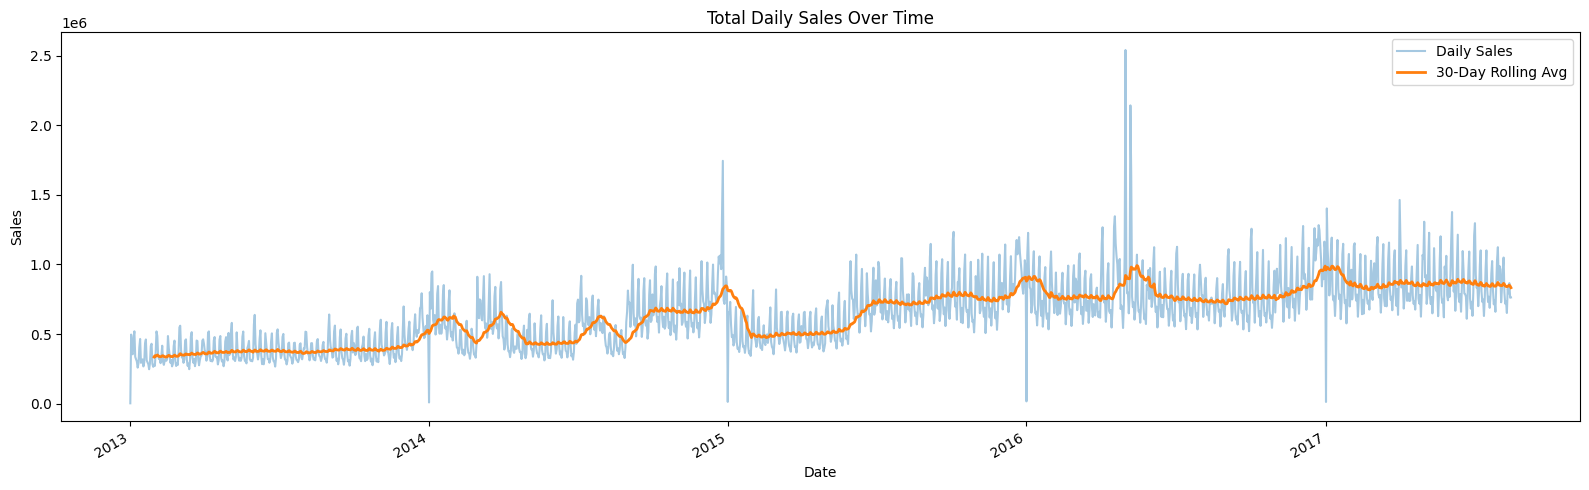

In [4]:
daily_sales = train_merged.groupby('date')['sales'].sum()

plt.figure(figsize=(16, 5))
daily_sales.plot(alpha=0.4, label='Daily Sales')
daily_sales.rolling(30).mean().plot(label='30-Day Rolling Avg', linewidth=2)

plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


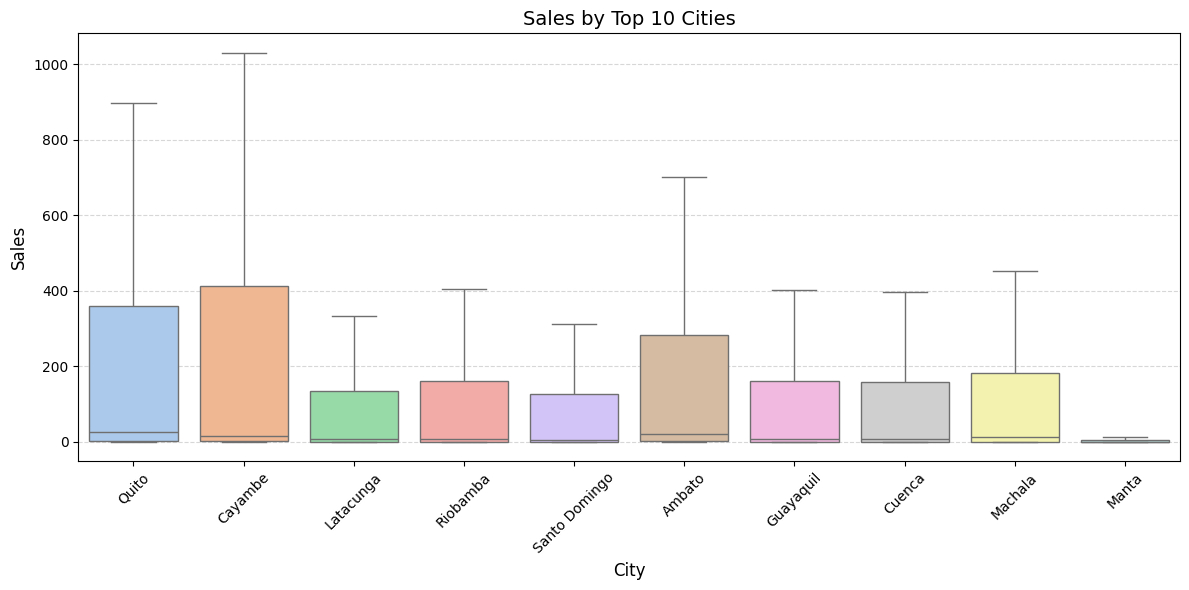

In [5]:
top_cities = train_merged['city'].value_counts().head(10).index
filtered = train_merged[train_merged['city'].isin(top_cities)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='city',
    y='sales',
    hue='city',           # explicitly set hue to suppress warning
    data=filtered,
    palette='pastel',
    showfliers=False
)

plt.legend([], [], frameon=False)  # hide the legend
plt.title("Sales by Top 10 Cities", fontsize=14)
plt.xlabel("City", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



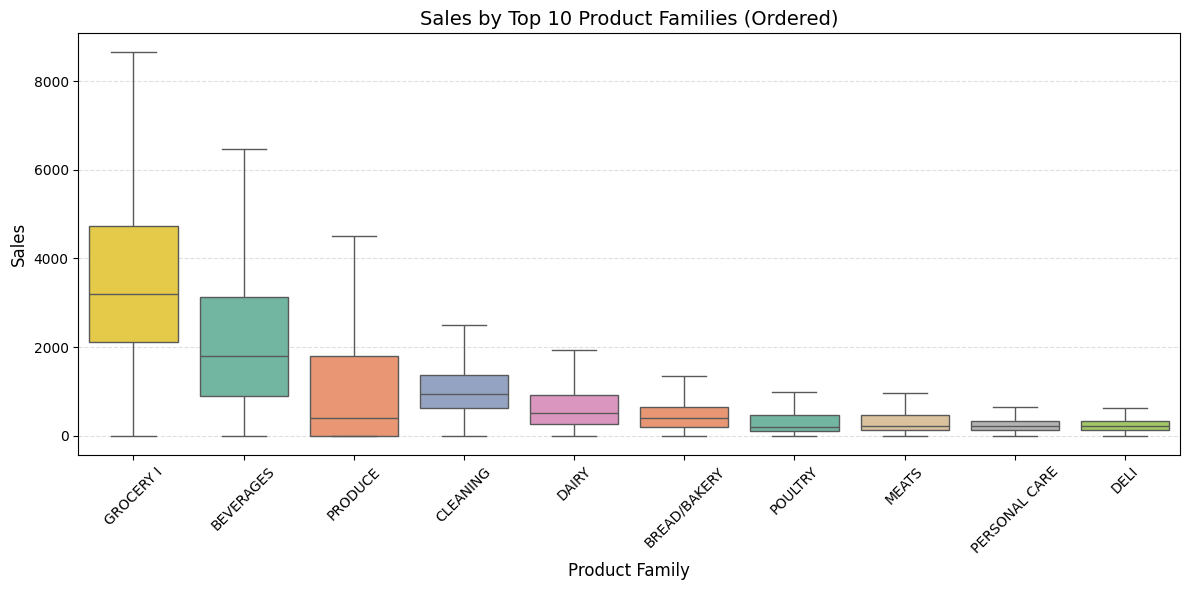

In [ ]:
# Make sure 'family' is a string 
train_merged['family'] = train_merged['family'].astype(str)

# Get top 10 families by total sales
top_10_families = (
    train_merged.groupby('family')['sales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Filter data
filtered_df = train_merged[train_merged['family'].isin(top_10_families.index)].copy()

# Order families left-to-right by total sales
ordered_families = top_10_families.index.tolist()

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='family',
    y='sales',
    hue='family',             
    data=filtered_df,
    order=ordered_families,    # enforce order
    palette='Set2',
    showfliers=False
)

plt.legend([], [], frameon=False)  # hide legend
plt.title("Sales by Top 10 Product Families (Ordered)", fontsize=14)
plt.xlabel("Product Family", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


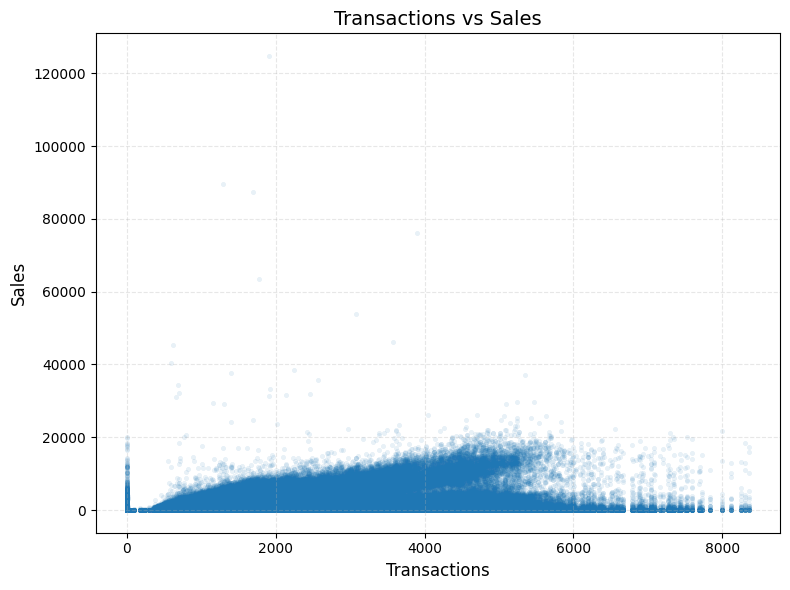

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='transactions',
    y='sales',
    data=train_merged,
    alpha=0.1,          # more transparent
    s=10,               # smaller points
    edgecolor=None
)

plt.title("Transactions vs Sales", fontsize=14)
plt.xlabel("Transactions", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

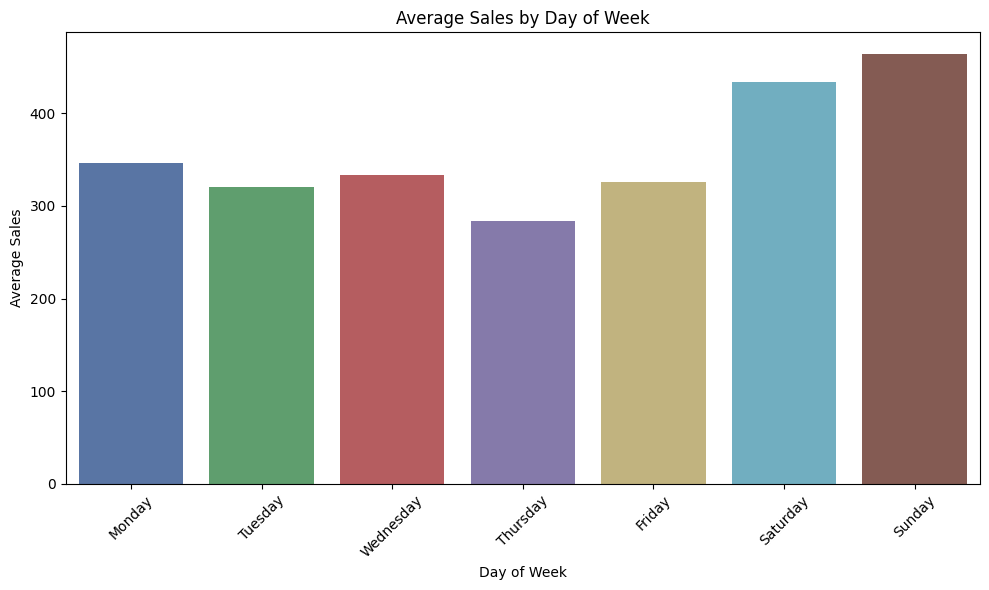

In [73]:
# Ensure day names and calculate average sales
train_merged['day_of_week'] = train_merged['date'].dt.day_name()
dow_sales = train_merged.groupby('day_of_week')['sales'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

# Define custom colors for each day
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974', '#64b5cd', '#8c564b']
palette_dict = dict(zip(dow_sales['day_of_week'], colors))

# Plot with hue to avoid warning
plt.figure(figsize=(10, 6))
sns.barplot(data=dow_sales, x='day_of_week', y='sales', hue='day_of_week', palette=palette_dict, legend=False)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


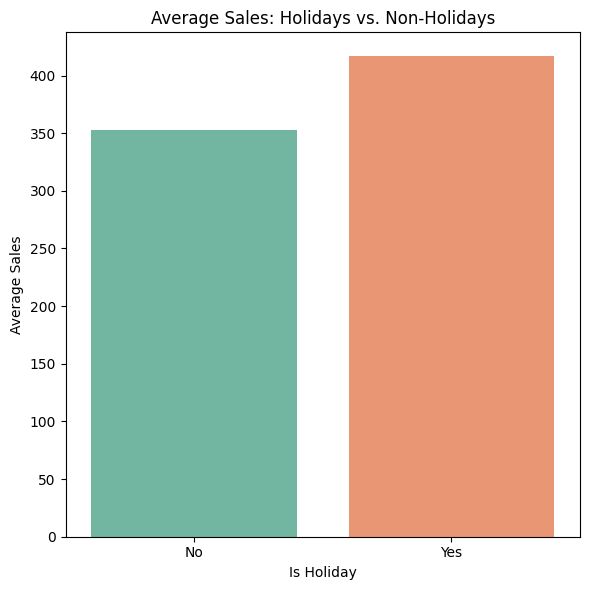

In [74]:
# Group sales by holiday flag
holiday_sales = train_merged.groupby('is_holiday')['sales'].mean().reset_index()

# Optional: map 0/1 to more readable labels
holiday_sales['is_holiday'] = holiday_sales['is_holiday'].map({0: 'No', 1: 'Yes'})

# Define custom colors
palette_dict = {'No': '#66c2a5', 'Yes': '#fc8d62'}

# Plot with hue and no legend (to silence the FutureWarning)
plt.figure(figsize=(6, 6))
sns.barplot(data=holiday_sales, x='is_holiday', y='sales', hue='is_holiday', palette=palette_dict, legend=False)
plt.title('Average Sales: Holidays vs. Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()


In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error

# Preprocessing and Feature Engineering
for df in [train_merged, test]:
    df['date'] = pd.to_datetime(df['date'])
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

le_family = LabelEncoder()
train_merged['family'] = le_family.fit_transform(train_merged['family'])
test['family'] = le_family.transform(test['family'])

train_merged['store_nbr'] = train_merged['store_nbr'].astype(int)
test['store_nbr'] = test['store_nbr'].astype(int)

# Handle outliers
train_merged['sales'] = np.clip(train_merged['sales'], 0, 5000)

# Add avg sales per store/family combo
for df in [train_merged, test]:
    if 'avg_sales_store_family' in df.columns:
        df.drop(columns=['avg_sales_store_family'], inplace=True)

avg_sales = train_merged.groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
avg_sales.rename(columns={'sales': 'avg_sales_store_family'}, inplace=True)

train_merged = train_merged.merge(avg_sales, on=['store_nbr', 'family'], how='left')
test = test.merge(avg_sales, on=['store_nbr', 'family'], how='left')
test['avg_sales_store_family'] = test['avg_sales_store_family'].fillna(0)

# Add log features
train_merged['log_avg_sales_store_family'] = np.log1p(train_merged['avg_sales_store_family'])
test['log_avg_sales_store_family'] = np.log1p(test['avg_sales_store_family'])

train_merged['log_onpromotion'] = np.log1p(train_merged['onpromotion'])
test['log_onpromotion'] = np.log1p(test['onpromotion'])

# Feature selection
features = [
    'store_nbr', 'family', 'onpromotion',
    'dayofweek', 'month', 'year', 'is_weekend',
    'dayofmonth', 'weekofyear', 'is_month_start', 'is_month_end',
    'avg_sales_store_family', 'log_avg_sales_store_family', 'log_onpromotion'
]

X_train = train_merged[features]
y_train = np.log1p(train_merged['sales'])  # log1p for RMSLE
X_test = test[features]

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmsle_scores = []

print("Performing 5-Fold Cross-Validation:")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model_cv = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model_cv.fit(X_tr, y_tr)

    y_val_pred_log = model_cv.predict(X_val)
    y_val_pred = np.expm1(y_val_pred_log)
    y_val_true = np.expm1(y_val)

    y_val_pred = np.clip(y_val_pred, 0, None)
    score = np.sqrt(mean_squared_log_error(y_val_true, y_val_pred))
    rmsle_scores.append(score)

    print(f"Fold {fold + 1} RMSLE: {score:.5f}")

print(f"\n Average RMSLE: {np.mean(rmsle_scores):.5f}")
print(f" Std Dev RMSLE: {np.std(rmsle_scores):.5f}")

# Final model training on all data
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Final prediction
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_pred = np.clip(y_pred, 0, None)

test['sales'] = y_pred
submission = test[['id', 'sales']]
submission.to_csv("data/submission.csv", index=False)

# Prediction stats
print("\n Model Prediction Statistics:")
print(f"Min:      {np.min(y_pred):.2f}")
print(f"Max:      {np.max(y_pred):.2f}")
print(f"Mean:     {np.mean(y_pred):.2f}")
print(f"Median:   {np.median(y_pred):.2f}")
print(f"Std Dev:  {np.std(y_pred):.2f}")

Performing 5-Fold Cross-Validation:
Fold 1 RMSLE: 0.48893
Fold 2 RMSLE: 0.49124
Fold 3 RMSLE: 0.49192
Fold 4 RMSLE: 0.49001
Fold 5 RMSLE: 0.48365

 Average RMSLE: 0.48915
 Std Dev RMSLE: 0.00294

 Model Prediction Statistics:
Min:      0.00
Max:      6541.87
Mean:     384.89
Median:   23.32
Std Dev:  927.60


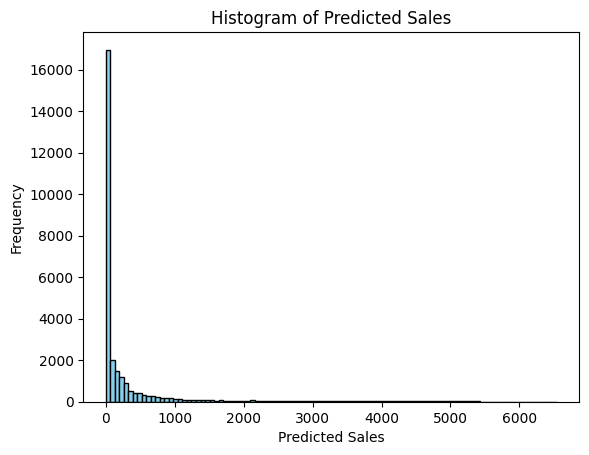

Number of predictions = 0: 1128


In [79]:
import matplotlib.pyplot as plt
plt.hist(test['sales'], bins=100, color='skyblue', edgecolor='black')
plt.title("Histogram of Predicted Sales")
plt.xlabel("Predicted Sales")
plt.ylabel("Frequency")
plt.show()
print("Number of predictions = 0:", (test['sales'] == 0).sum())